# Lecture 3a: EEG Signal Analysis for Interactive Systems
Signal Processing for Interactive Systems

Cumhur Erkut (cer@create.aau.dk)

Aalborg University Copenhagen

Last edited: 2025-03-03

# EEG Time-Frequency Analysis for Interactive Applications
This notebook demonstrates key spectral and time-frequency methods for EEG analysis.
It covers:
- **Time-domain representation**
    - **Autocorrelation** (Identifying periodicity in EEG signals)
    - **Autoregressive (AR) Model** (Parametric spectral estimation)
- **Frequency-domain techniques**
    - **Periodogram** (Power Spectral Density estimation)
    - **Welch's method** (Improved PSD estimation using averaging)
    - **Multitaper Method** (Variance reduction in spectral estimation)
- **Time-frequency methods**
    - **Short-Time Fourier Transform (STFT)** (Time-frequency analysis)
- **Other methods, recent developments**


In [45]:
!pip install spectrum # used in AR model and multitapering (pmtm)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, welch, correlate, stft, spectrogram, windows
from spectrum import pmtm, aryule, marple_data, arma2psd

## 1. Introduction
EEG signals are oscillatory signals that are commonly analyzed in both the time and frequency domains.
The fundamental goal of spectral estimation is to determine how power is distributed across different frequencies.

Here, the EEG signal is modeled as:

$$x(t) = A_1 \sin(2\pi f_1 t) + A_2 \sin(2\pi f_2 t) + n(t) ,$$

where $f_1$, and $f_2$ are the frequencies present in the signal, and $n(t)$ is noise.


In [66]:
# Simulated EEG Signal Parameters
fs = 256  # Sampling frequency (Hz)
t = np.arange(0, 10, 1/fs)  # 10 seconds of data
signal = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t) + 10*np.sin(2 * np.pi * 40 * t) + np.random.normal(0, 0.5, len(t))


## 2. Time-Domain Representation


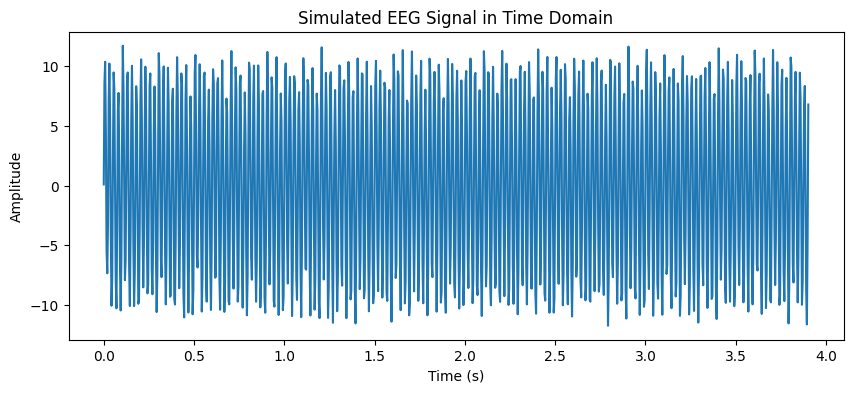

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], signal[:1000])  # Show first few seconds
plt.title("Simulated EEG Signal in Time Domain")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Autocorrelation Analysis
Autocorrelation identifies periodicities in the signal by computing:

$$R_x(\tau) = \sum_{n} x[n] x[n - \tau]$$



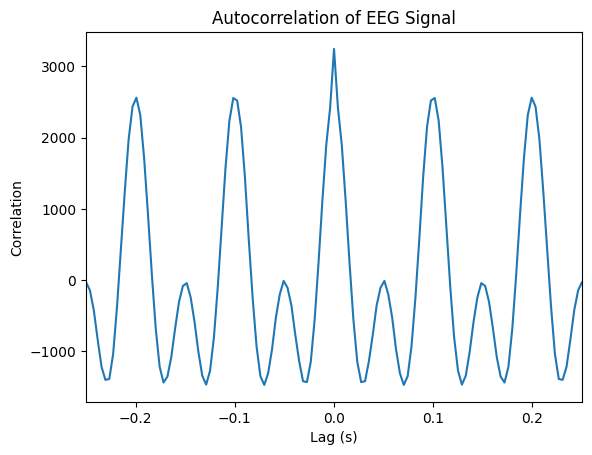

In [49]:
corr = correlate(signal, signal, mode='full')
lag = np.arange(-len(signal) + 1, len(signal)) / fs
plt.figure()
plt.plot(lag, corr)
plt.title("Autocorrelation of EEG Signal")
plt.xlabel("Lag (s)")
plt.xlim(-0.25, 0.25) # limit to a few peaks of lags
plt.ylabel("Correlation")
plt.show()


<ipython-input-50-edfe2c47d709>:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/lag, corr)


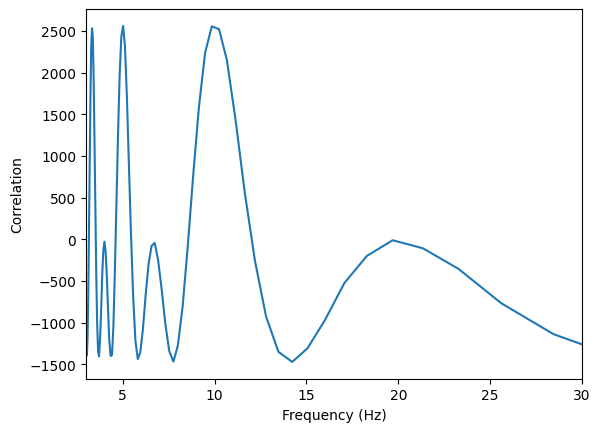

In [50]:
# change the lag in seconds to frequencies
plt.plot(1/lag, corr)
plt.xlim(3, 30)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation")
plt.show()


### Autoregressive (AR) Model
The AR model estimates the power spectrum by fitting the data to a parametric model:

$$ x[n] = \sum_{p=1}^{P} a_p x[n - p] + e[n] $$


In [57]:
# Sensitive to P
ar_order = 20
# Estimated a coefficients using Yule-Walker
ar_coeffs,_,noise_var = aryule(signal, ar_order)

# Convert to PSD
psd_ar = arma2psd(ar_coeffs, rho=0.5, T=1/fs, norm=True)

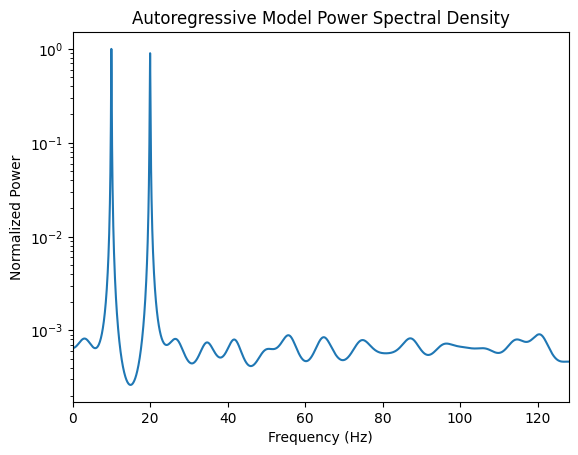

In [56]:
# Visualize
plt.figure()
plt.semilogy(np.linspace(0, fs, len(psd_ar)), psd_ar)
plt.xlim(0, fs/2)
plt.title("Autoregressive Model Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Power")
plt.show()

#### How to get the right model parameter *P* ?

Minimize

- Akaike information criterion (AIC):

$$
AIC = N \ln \left(\sigma^2\right)+2 P
$$

- Bayesian information criterion (BIC):

$$
BIC=N \ln \left(\sigma^2\right)+P \ln (N)
$$

- Final prediction error (FPE):

$$
F P E=\sigma^2(N+P+1) /(N-P-1)
$$

where $N$ is the signal length, $\sigma^2$ is the noise variance, and $P$ is the model parameter.

## 3. Spectral Estimation
### 3.1 Periodogram Method
The periodogram estimates the power spectral density (PSD) using the squared magnitude of the Fourier Transform:

$$ P(f) = \frac{1}{N F_s}\left|\sum_{n=1}^N x[n] w[n] e^{-j 2 \pi f n / F_s}\right|^2$$

where *w*[*n*] is a window function (think rectangular).


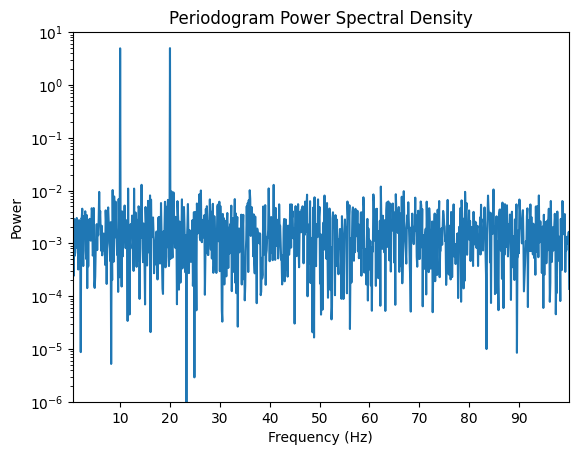

In [ ]:
freqs, psd = periodogram(signal, fs=fs)
plt.figure()
plt.semilogy(freqs, psd)
plt.title("Periodogram Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.xlim(0.5, 100)
plt.ylim(0.000001, 10)
plt.xticks(np.arange(10, 100, 10))
plt.ylabel("Power")
plt.show()

### 3.2 Welch's Method
Welch’s method improves PSD estimation by dividing the signal into overlapping segments and averaging the periodograms:
$$ P_{\rm Welch}(f) = \frac{1}{K} \sum_{k=1}^{K} P_k(f) $$

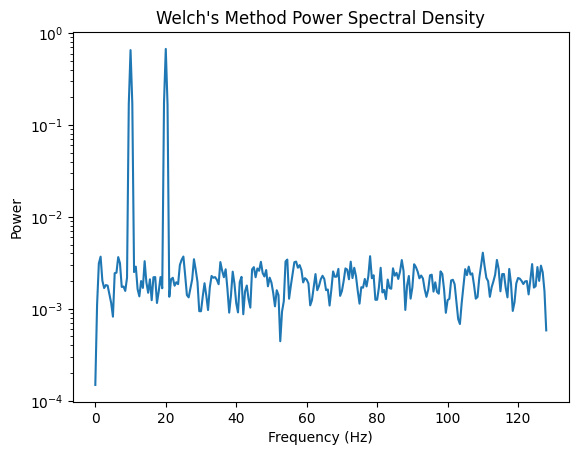

In [ ]:
freqs_welch, psd_welch = welch(signal, fs=fs, nperseg=512) #noverlap default is nperseg/2
plt.figure()
plt.semilogy(freqs_welch, psd_welch)
plt.title("Welch's Method Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()

### 3.3 Multitaper Method
The multitaper method reduces spectral variance by applying multiple tapers to the signal:

$$ P_{\rm MT}(f) = \frac{1}{K} \sum_{k=1}^{K} \left| X_k(f) \right|^2 $$

To plot the spectrum please use Multitapering class instead of
pmtm. Same syntax but more correct plot. This plotting functionality is kept for
book-keeping but lacks sampling option, and amplitude is not correct.


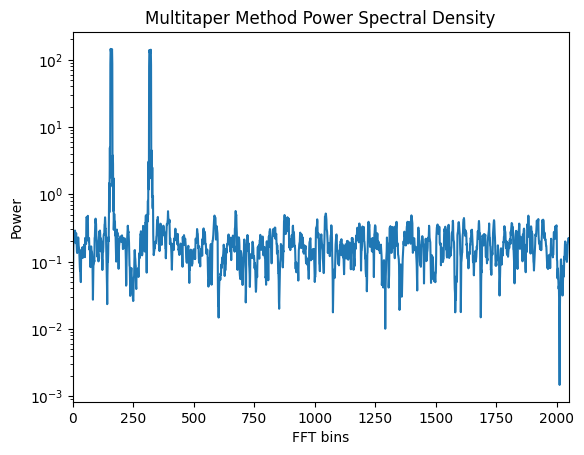

In [62]:
Sk, weights, _ = pmtm(signal, NW=2.5, show=True)
# Change nw, note that the autoplot has bins instead frequencies
plt.xlim(0,len(weights)/2)
plt.title("Multitaper Method Power Spectral Density")
plt.xlabel("FFT bins")
plt.ylabel("Power")
plt.show()

## 4. Time-Frequency Analysis
###  4.1 Short-Time Fourier Transform (STFT)
Recall from the last lecture, we obtain the **STFT** as

$$ X_N(\omega_f, l) = \sum_{n=-\infty}^\infty w_n x_{n+lL} \mathrm{e}^{-j\omega_fn} = \sum_{n=0}^{N-1} (w_nx_{n+lL}) \mathrm{e}^{-j\omega_fn} $$
```{image} https://github.com/SMC-AAU-CPH/med4-ap-jupyter/blob/main/lecture7_Fourer_Transfom/figures/ap7StftFrameHop.png?raw=1
:alt: Frame hop sketch
:width: 90%
:align: center
```



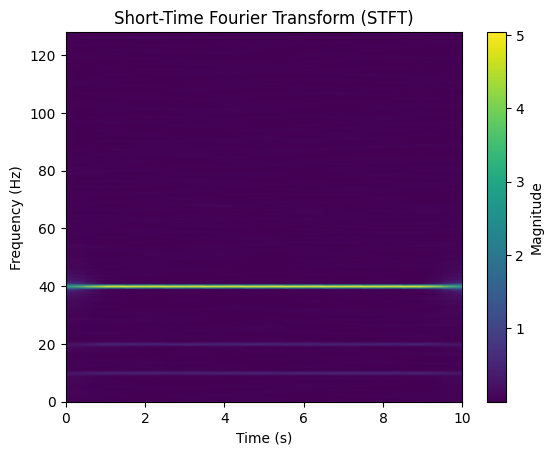

In [71]:
f, t, Zxx = stft(signal, fs, nperseg=512)
plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title("Short-Time Fourier Transform (STFT)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Magnitude")
plt.show()

# Summary
In time-domain,
- **Autocorrelation** helps reveal periodic components.
- **Autoregressive Model** provides a smooth parametric spectral estimation (gateway to frequency domain).
In frequency-domain
- **Periodogram** provides a simple power spectrum estimate but is noisy.
- **Welch's method** improves stability by averaging over overlapping segments.
- **Multitaper method** reduces variance for a more stable spectrum.
In time-frequency,
- **STFT** enables time-frequency visualization of EEG signals.
- Is a gateway to other time-frequency tilings.

## Activities

- Study other methods from the paper: Zhang-2019-EEGTF
- Run all techniques on the real data
- Run all techniques within MNE, on [simulated](https://mne.tools/stable/auto_examples/time_frequency/time_frequency_simulated.html) or [real data](https://mne.tools/stable/auto_tutorials/intro/10_overview.html#time-frequency-analysis)
- Check how to apply [EEG data to Machine Learning on Edge Impulse](https://docs.edgeimpulse.com/experts/novel-sensor-projects/eeg-data-machine-learning-part-1)

--2025-03-02 09:52:56--  https://raw.githubusercontent.com/SMC-AAU-CPH/SPIS/main/03-Fourier-Transform/data/NewEEGSignal.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4154 (4.1K) [application/octet-stream]
Saving to: ‘data/NewEEGSignal.mat’

NewEEGSignal.mat    100%[===================>]   4.06K  --.-KB/s    in 0s      

2025-03-02 09:52:56 (29.2 MB/s) - ‘data/NewEEGSignal.mat’ saved [4154/4154]



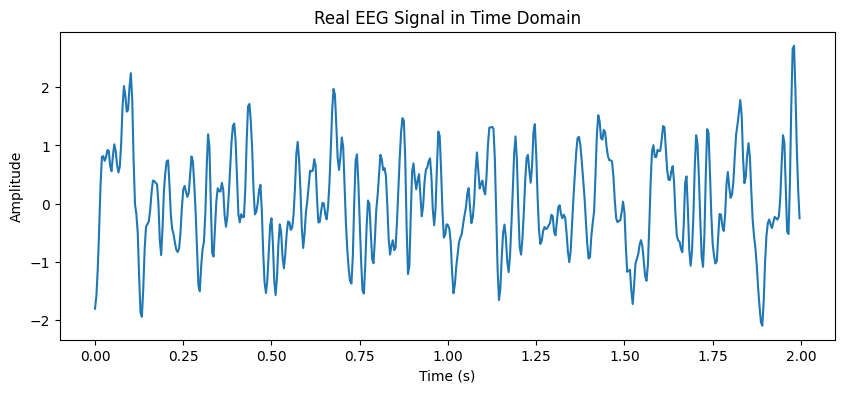

In [ ]:
# Starter code for real data (MATLAB format)
try:
  import google.colab
  IN_COLAB = True
  !mkdir -p data
  !wget https://raw.githubusercontent.com/SMC-AAU-CPH/SPIS/main/03-Fourier-Transform/data/NewEEGSignal.mat -P data
except:
  IN_COLAB = False

from scipy.io import loadmat

# Load the signal from the .mat file
signal = loadmat('./data/NewEEGSignal.mat')['NewEEGSignal'][0]
fs = 256 #Hz
t = np.arange(0, 512) / fs
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], signal[:1000])  # Show first few seconds
plt.title("Real EEG Signal in Time Domain")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# etc


In [ ]:
# You can also clone the Zheng-2019 Chapter 6 code in MATLAB and use their data,
# tasks, and analysis tools (e.g. Continuous Wavelet Transform)
# !git clone https://github.com/zhangzg78/eegbook

# Projects Round up
- G1: Correlation between immersion and task performance in VR. EEG is one metric. Task, self reports, physiological signals.
- G2: Hackathon with EG: VR time traveling app. GenAI for visuals. EEG experimentation feasible through modificatioin of the EEG data to ML/Edge Impulse
- Wellness meditation XR/MR combining different sensors, preferably using existing datasets. Recommendation: Look at the aesthetics, mechanics, dynamics of teh app, then go to simple signal processing.